# Training Fashion MNIST Dataset on GPU using pytorch

### Importing the dataset

In [1]:
import pandas as pd 
from sklearn.model_selection import train_test_split
import torch 
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn 
import torch.optim as optim
import matplotlib.pyplot as plt 
from torchinfo import summary
## Setting random seed for reproducibility 
torch.manual_seed(42)

### Checking for GPU

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### Loading the dataset

In [3]:
df = pd.read_csv("/kaggle/input/fashionmnist/fashion-mnist_train.csv")
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Showing some sample images

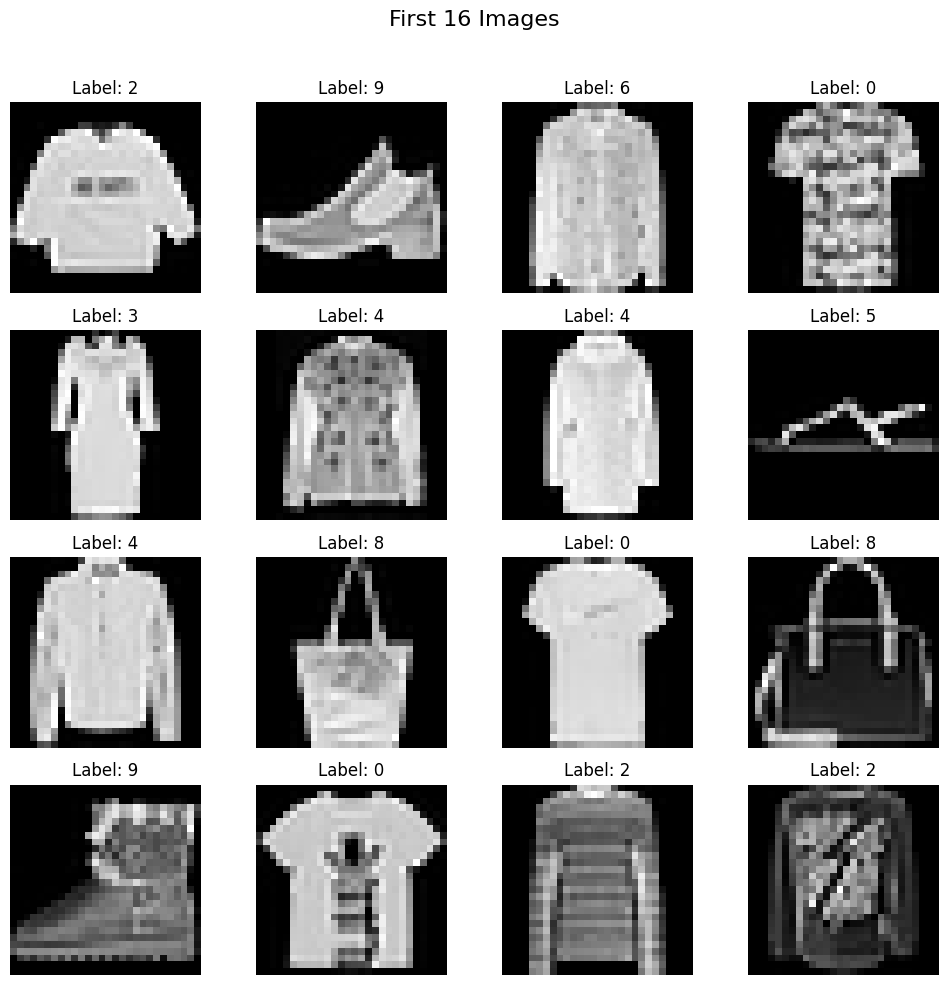

In [6]:
# Create a 4x4 grid of images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 Images", fontsize=16)

# Plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)  # Reshape to 28x28
    ax.imshow(img, cmap = 'gray')  # Display in grayscale
    ax.axis('off')  # Remove axis for a cleaner look
    ax.set_title(f"Label: {df.iloc[i, 0]}")  # Show the label

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()


### Feature and label extraction

In [7]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

### Train test split of the data

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Scaling the features

In [11]:
X_train = X_train/255.0
X_test = X_test/255.0

### Creating a custom dataset class

In [12]:
class CustomDataset(Dataset):
    
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype = torch.float32)
        self.labels = torch.tensor(labels, dtype = torch.long)
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        return self.features[index], self.labels[index]

In [13]:
## Creating train_dataset object
train_dataset = CustomDataset(X_train, y_train)

## creating test dataset object 
test_dataset = CustomDataset(X_test, y_test)

### Creating train and test loader

In [14]:
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Creating the neural network

In [15]:
class MyNN(nn.Module):
    
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,10)
        )
    ## we don't explicitly add the softmax layer at last as in pytorch the cross entropy loss automatically adds that
    
    def forward(self,x):
        return self.model(x)

In [16]:
epochs = 100
lr = 0.1

In [17]:
## Initiating the model
model = MyNN(X_train.shape[1])
## moving model execution to gpu
model = model.to(device)

print(summary(model))

## loss function
criterion = nn.CrossEntropyLoss()

## Optimizer 
optimizer = optim.SGD(model.parameters(), lr = lr)

Layer (type:depth-idx)                   Param #
MyNN                                     --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       100,480
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       8,256
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       650
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0


In [18]:
## Training loop

for epoch in range(epochs):
    total_epoch_loss = 0
    
    for batch_features, batch_labels in train_loader:
        
        ##Move the data to gpu
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        
        ## forward pass
        outputs = model(batch_features)
        
        ## loss calculation 
        loss = criterion(outputs, batch_labels)
        
        ## back pass
        optimizer.zero_grad()
        loss.backward()
        
        ## Update
        optimizer.step()
        
        total_epoch_loss += loss.item()
    avg_loss = total_epoch_loss/(len(train_loader))
    print(f"Epoch: {epoch+1}, loss: {avg_loss}")

Epoch: 1, loss: 0.6352872455318769
Epoch: 2, loss: 0.4304986933817466
Epoch: 3, loss: 0.38612620331346986
Epoch: 4, loss: 0.3584607186516126
Epoch: 5, loss: 0.3376494685560465
Epoch: 6, loss: 0.3227646785800656
Epoch: 7, loss: 0.30785389595727125
Epoch: 8, loss: 0.29498188248028356
Epoch: 9, loss: 0.2854692431092262
Epoch: 10, loss: 0.27467057487616936
Epoch: 11, loss: 0.26830568559716145
Epoch: 12, loss: 0.25814215187107525
Epoch: 13, loss: 0.24940819021190205
Epoch: 14, loss: 0.24444738084822892
Epoch: 15, loss: 0.23859191479658087
Epoch: 16, loss: 0.23155898495018482
Epoch: 17, loss: 0.22562562109405795
Epoch: 18, loss: 0.220296459933122
Epoch: 19, loss: 0.21206333881616593
Epoch: 20, loss: 0.20960091057543953
Epoch: 21, loss: 0.20624992236122489
Epoch: 22, loss: 0.19986102367161462
Epoch: 23, loss: 0.19530413204431535
Epoch: 24, loss: 0.19312162966746838
Epoch: 25, loss: 0.18764106344679993
Epoch: 26, loss: 0.1836644180783381
Epoch: 27, loss: 0.1801829884586235
Epoch: 28, loss: 0.1

### Evaluation

In [19]:
# set model to eval mode
model.eval()

## in evaluation mode, some features are deactivated like dropout and batchnormalization

MyNN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [20]:
# evaluation code
total = 0
correct = 0

with torch.no_grad():
    
    for batch_features, batch_labels in test_loader:
        ##Move the data to gpu
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        outputs = model(batch_features) # shape - (32,10) each containing probability value
        _, predicted = torch.max(outputs,1)
        
        total += batch_labels.shape[0]
        correct += (predicted == batch_labels).sum().item()
        
print(f"Accuracy = {round((correct/total)*100,2)}%")

Accuracy = 88.98%
